# Convolutional Neural Network Image Classification: MNIST
In this notebook, a Convolutional Neural Network will be build from scratch and trained on the MNIST dataset. The MNIST dataset is a dataset containing hand-written images of digits. The end goal is to label the images with their corresponding digit. Take a look at the Feedforward Neural Network Image Classification of the MNIST dataset for the exploring of the MNIST dataset and the explanation about the data preparation.    

## Import Libraries

In [1]:
import torch
import torch.nn as nn
from torch.optim import Adam 
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchmetrics.classification import MulticlassAccuracy
import torchvision
from torchvision.transforms import ToTensor
import numpy as np
import matplotlib.pyplot as plt
import copy

c:\python39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


ModuleNotFoundError: No module named 'torchmetrics'

## PyTorch Dataset Object
In this part, a class will be created for the datasets. This class will contain Python functions such as length of the dataset and get the specific item (=slicing) from the dataset.

This class will transform the original pixel value range from 0->255 to 0->1 and the labels will be transformed to a one-hot encoding presentation.

In [2]:
class CTDataset(Dataset):
    def __init__(self, data):
        self.x, self.y = data
        self.x = self.x/ 255.
        self.y = F.one_hot(self.y, num_classes=10).to(float)
    def __len__(self):
        return self.x.shape[0]
    def __getitem__(self, ix):
        return self.x[ix], self.y[ix]

In [3]:
train_set = torch.load("MNIST\\MNIST\\processed\\training.pt")
test_set = torch.load("MNIST\\MNIST\\processed\\test.pt")

train_ds, val_ds = random_split(CTDataset(train_set),[50000,10000])
dataset_sizes = {'train':50000,'val':10000}
test_ds = CTDataset(test_set)

## PyTorch DataLoader Object
The Dataset objects can be put inside a DataLoader class. This is very useful because batches can be created with this class. Batches of data samples are useful during the training process. 

This will create batches of 100 digit images. The length of the Dataloader object will be 60000/100=600. 

In [4]:
train_dl = DataLoader(train_ds, batch_size=5)
val_dl = DataLoader(val_ds, batch_size=5)

dataloaders = {'train': train_dl, 'val': val_dl}

len(train_dl), len(val_dl)

(10000, 2000)

## The Convolutional Neural Network Architecture
In this section, a definition of the Neural Network will be created. In this example, two convolutional layers followed by a ReLU non-linearity and average pooling are the first part of the Convolutional Neural Network. The last part is the flattening of the feature maps followed by the linear layers.

In [5]:
class ConvNeuralNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Sequential(
            # 1 input image will be converted to 16 feature maps 
            nn.Conv2d(1,16,5,stride=1,padding=2),
            nn.ReLU(),
            nn.AvgPool2d(2,stride=2)
        )
        self.conv2 = nn.Sequential(
            # 16 feature maps will be converted to 32 feature maps
            nn.Conv2d(16,32,5,stride=1,padding=2),
            nn.ReLU(),
            nn.AvgPool2d(2,stride=2)
        )
        self.out = nn.Linear(32*7*7,10)
    def forward(self,x):
        x = self.conv1(x)
        x = self.conv2(x)
        # The output of the last conv layer is flattened (batch size, 32x7x7)
        x = x.view(x.size(0),-1)
        x = self.out(x)
        return x

In [6]:
model = ConvNeuralNet()

## Training
A function is created to automise the training of the Convolutional Neural Network.

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [8]:
def train_model(model, criterion, optimizer, n_epochs=20):
    best_model_wts = copy.deepcopy(model.state_dict())  # takes a copy of the model and also of all the inner layers, weights, biases
    best_acc = 0.0

    # Train loop
    train_losses = []
    val_losses = []
    for epoch in range(n_epochs):
        print('Epoch {}/{}'.format(epoch, n_epochs-1))
        print('-'*10)

        # each epoch has a training and validation phase
        for phase in ['train','val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0.0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)  # store the inputs to the selected device
                labels = labels.to(device)  # store the labels to the selected device
                inputs = inputs.unsqueeze(1)

                # forward step
                with torch.set_grad_enabled(phase=='train'):    # gradient calculation will only be enabled when in training mode
                    outputs = model(inputs)
                    preds = torch.max(outputs)
                    _, preds = torch.max(outputs,-1)    # get the indices of the max values --> prediction
                    _, labels = torch.max(labels,-1)    # get the indices of the max values (one-hot encoding) --> label
                    loss = criterion(outputs, labels)

                    # backward step and optimise only in train phase
                    if phase=='train':
                        optimizer.zero_grad()   # Pytorch keeps track of the gradients over multiple epochs, therefore initialise it to 0
                        loss.backward()
                        optimizer.step()    # update the model parameters using the defined optimizer 
                
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds==labels.data) 
            
            epoch_loss = running_loss/dataset_sizes[phase]
            epoch_acc = running_corrects.double()/dataset_sizes[phase]

            if phase == 'train':
                train_losses.append(epoch_loss)
            else:
                val_losses.append(epoch_loss)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase,epoch_loss,epoch_acc))

            # deep copy the model
            if phase=='val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            
            print()

    print('Best val Acc: {:.4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return train_losses, val_losses


In [9]:
optimizer = Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [10]:
epochs = 25
train_losses, val_losses = train_model(model,criterion,optimizer,n_epochs=epochs)

epoch = list()
for i in range(epochs):
    epoch.append(i)

Epoch 0/24
----------
train Loss: 0.1345 Acc: 0.9585

val Loss: 0.0906 Acc: 0.9723

Epoch 1/24
----------
train Loss: 0.0496 Acc: 0.9850

val Loss: 0.0535 Acc: 0.9842

Epoch 2/24
----------
train Loss: 0.0335 Acc: 0.9902

val Loss: 0.0365 Acc: 0.9890

Epoch 3/24
----------
train Loss: 0.0246 Acc: 0.9925

val Loss: 0.0357 Acc: 0.9900

Epoch 4/24
----------
train Loss: 0.0191 Acc: 0.9940

val Loss: 0.0384 Acc: 0.9893

Epoch 5/24
----------
train Loss: 0.0159 Acc: 0.9954

val Loss: 0.0459 Acc: 0.9890

Epoch 6/24
----------
train Loss: 0.0135 Acc: 0.9958

val Loss: 0.0457 Acc: 0.9888

Epoch 7/24
----------
train Loss: 0.0113 Acc: 0.9967

val Loss: 0.0518 Acc: 0.9884

Epoch 8/24
----------
train Loss: 0.0105 Acc: 0.9968

val Loss: 0.0447 Acc: 0.9893

Epoch 9/24
----------
train Loss: 0.0098 Acc: 0.9970

val Loss: 0.0472 Acc: 0.9890

Epoch 10/24
----------
train Loss: 0.0086 Acc: 0.9974

val Loss: 0.0481 Acc: 0.9895

Epoch 11/24
----------
train Loss: 0.0078 Acc: 0.9977

val Loss: 0.0523 Acc

The loss function is plotted for each epoch during the training procedure.

Text(0.5, 1.0, 'Cross entropy(per batch)')

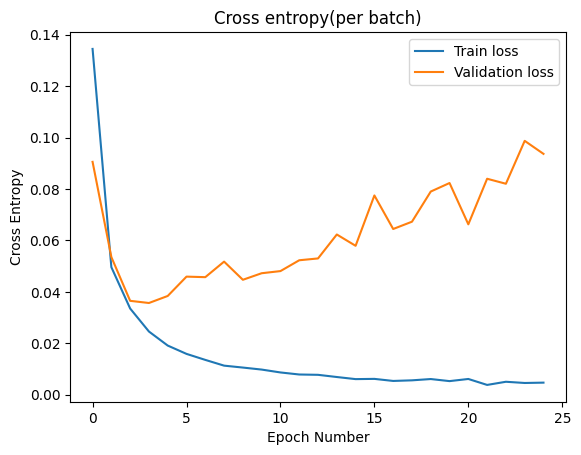

In [12]:
plt.plot(epoch, train_losses, label="Train loss")
plt.plot(epoch, val_losses, label="Validation loss")
plt.legend()
plt.xlabel('Epoch Number')
plt.ylabel('Cross Entropy')
plt.title('Cross entropy(per batch)')

The loss is already very low from the first epoch. The validation loss also starts to rise again after a certain amount of epochs. This is because overfitting of the model on the training set is occurring. Therefore, the weights of the model with the best validation accuracy are stored.

## Predicting using the Trained Convolutional Neural Network

First, we will take a look at the predictions on 2000 samples of the training dataset.

In [13]:
xs, ys = train_ds[0:2000]

The predicted labels using the trained Neural Network are computed below:

In [14]:
model.eval()
xs = xs.unsqueeze(1)
ys_pred = model(xs).argmax(axis=1)

Plot 40 predictions:

In [15]:
xs = xs.squeeze(1)

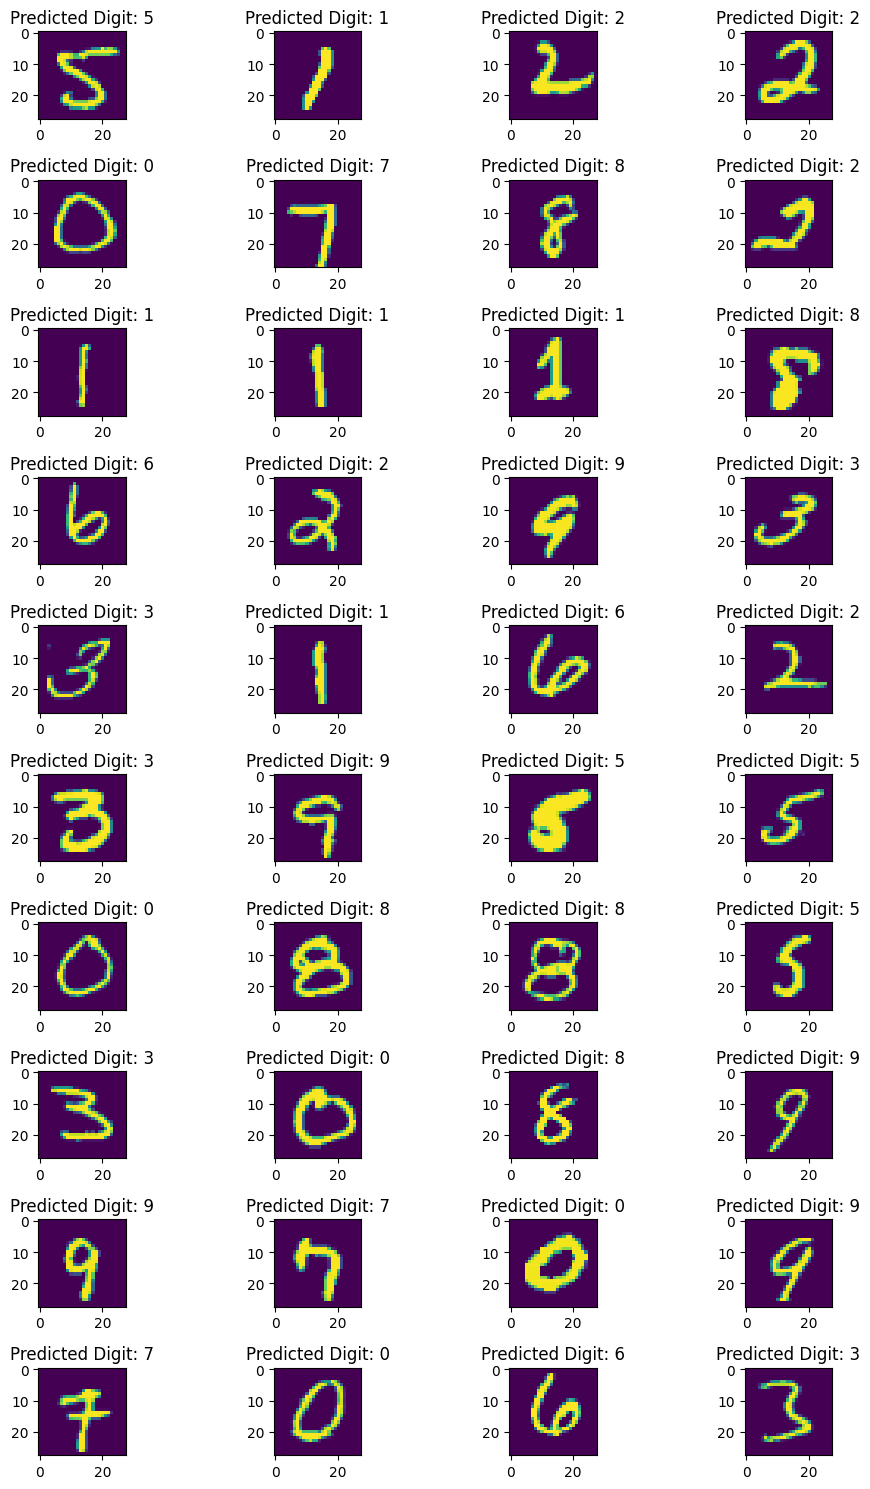

In [16]:
fig, ax = plt.subplots(10,4,figsize=(10,15))
for i in range(40):
    plt.subplot(10,4,i+1)
    plt.imshow(xs[i])
    plt.title(f'Predicted Digit: {ys_pred[i]}')
fig.tight_layout()
plt.show()

Untill now, we have only looked at the predictions of training samples. To check the generalisability of the trained Neural Network, the predictions of the test dataset are looked at:

In [18]:
xs, ys = test_ds[:2000]
xs = xs.unsqueeze(1)
ys_pred = model(xs).argmax(axis=1)

Plot 40 predictions:

In [19]:
xs = xs.squeeze(1)

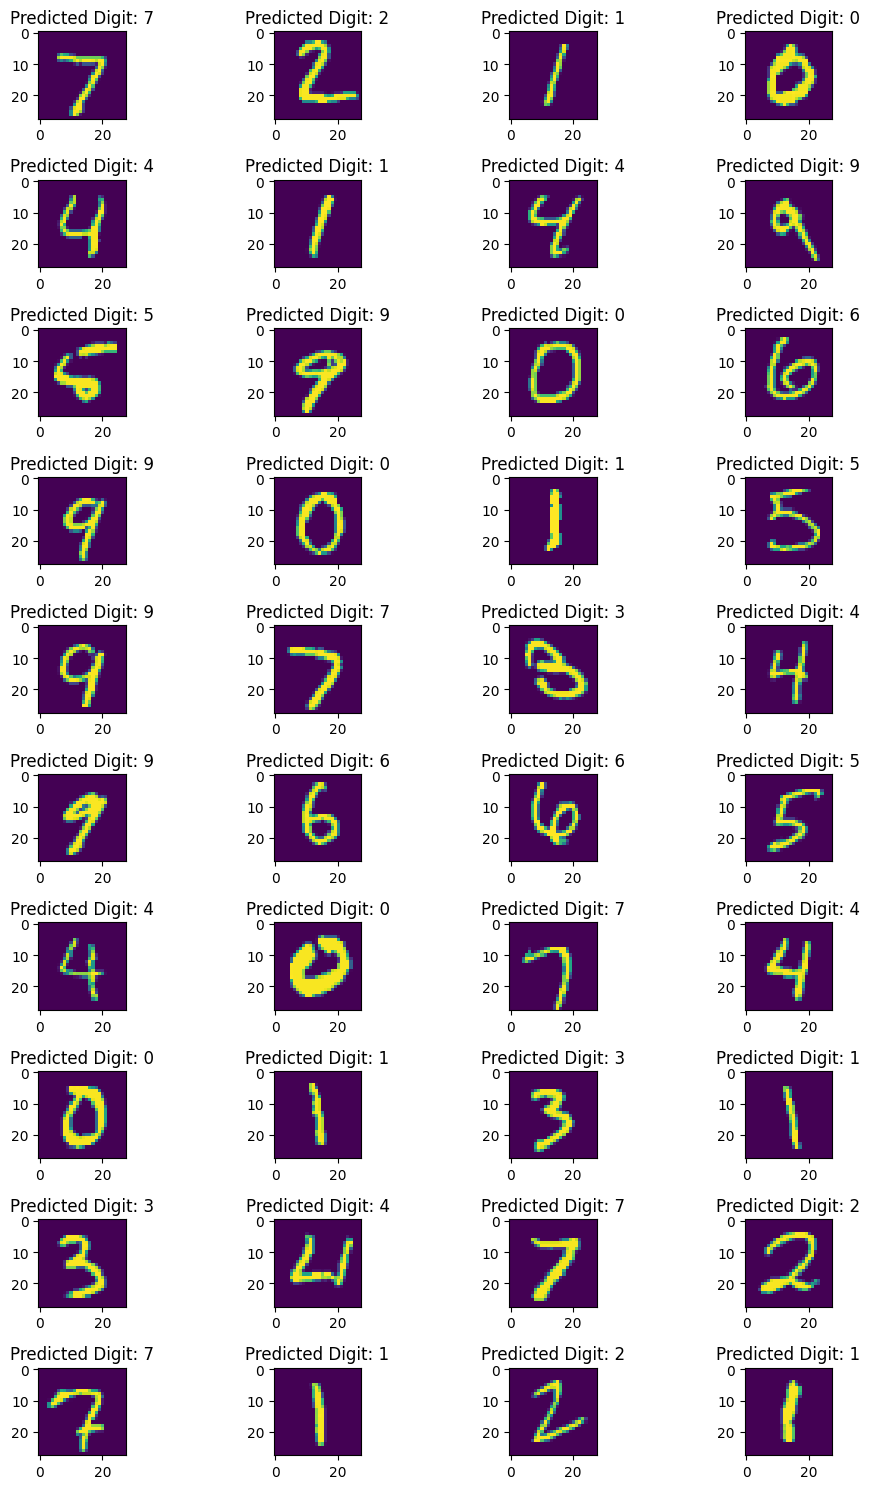

In [20]:
fig, ax = plt.subplots(10,4,figsize=(10,15))
for i in range(40):
    plt.subplot(10,4,i+1)
    plt.imshow(xs[i])
    plt.title(f'Predicted Digit: {ys_pred[i]}')
fig.tight_layout()
plt.show()

The trained Convolutional Neural Network also performs very well on the test dataset. 

## Evaluation

In [21]:
ys = ys.argmax(axis=1)
ys

tensor([7, 2, 1,  ..., 3, 9, 5])

The simple evaluation metric accuracy is used.

In [22]:
metric = MulticlassAccuracy(num_classes=10)
metric(ys_pred, ys)

tensor(0.9853)

The accuracy of 2000 images of the test dataset is above 98% (tensor(0.98)). This is higher than the accuracy achieved by the Feedforward Neural Network. 